In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import h5py
import os
import scipy.stats as stats
from scipy.special import gamma as gammafunc
from scipy.special import logsumexp
import stan
import arviz as az
import nest_asyncio
nest_asyncio.apply()

In [2]:
from general_model import temporally_augment, filter_data_by_dict, temporal_aggregation, bin_data, model_sample, stan_sample

In [3]:
project_dir = '/data/florican/jamiesonball/Intern_Project'

data_dir = os.path.join(project_dir, 'data')
data_filepath = os.path.join(data_dir, 'BGD_daily_inc_fatalities.h5')

data = pd.read_hdf(data_filepath,
                   key='event_data')

data = temporally_augment(data)

# Bayesian Hypothesis Testing

This document is to explore and perform various hypotheses which may wish to be tested about different models. The first of these is to test whether there is a supposedly natural relation between the number of events and the probability of a fatality, and the second is to explore how well various logistic models compare against each other.

## The Bayes factor

To test the hypotheses and evaluate the likelihood of models in comparison to one another, it is necessary to find the Bayes factor, which is the statistic that compares the likelihood of one model against another. In order to do this, the marginal likelihood must be found, which involves computing an integral over the parameter space of the model parameters. To put this mathematically, the Bayes factor when comparing model $i$ against model $j$ is

\begin{equation}
    \mathrm{BF}_{i,j} = \mathrm{BayesFactor}(m_i,m_j) = \frac{p(m_i(X))}{p(m_j(X))}
\end{equation}
where the marginal likelihood

\begin{equation}
    m_i(X) = \int_{\Theta_i} p(X|\theta_i)\pi(\theta_i)\mathrm{d}\theta_i
\end{equation}
is the marginal likelihood of the data $X$ given model $i$, and $\Theta_i$ is the sample space for model $i$. Computing the Bayes factor therefore involves computing the marginal likelihood, which is an integration over the parameter space. In most models, this must be calculated numerically, for which several processes exist.

### Calculating the marginal likelihood

As has just been discussed, it will be necessary to use computational methods to calculate the marginal likelihood and thus the Bayes factor. I have researched four methods for performing this, which I discuss here.

#### The naïve Monte Carlo method

One way of calculating the marginal likelihood is to notice that

\begin{equation}
    m_i(X) = \int_{\Theta_i} p(X|\theta_i)\pi(\theta_i)\mathrm{d}\theta_i \approx \mathbb{E}_{\theta \sim \pi}\left(p(X|\theta\right)) \approx \frac{1}{T}\sum_{t=1}^Tp\left(X|\theta_t\right), \quad \theta_t\overset{\mathrm{iid}}{\sim}\pi.
\end{equation}

Whilst being very computationally inexpensive, the simplicity of this method means that it can be unreliable. This method performs best where the prior and posterior distributions overlap significantly, which is not always going to be the case. When the posterior is peaked relative to the prior this method can be unreliable, as the few samples which come from the area of high a posteriori probability dominate the calculation of the integral, increasing the variance of the estimator.

#### An aside: Importance sampling methods (not implemented)

To overcome the problem of sampling from areas of low a posteriori density, it is possible to sample instead from some other chosen density which is intended to better represent the posterior distribution. However, these methods place strong requirements on the tails of the distributions, and the shapes of the distributions must be found using methods of moments or using maximum likelihood. The restrictions on the tails can make it difficult to find an appropriate sampling density for higher dimensions.

#### The bridge sampling estimator

The Bridge sampling method was originally developed to directly estimate the Bayes factor, but has since been adapted to estimate the marginal likelihood instead, which is the implementation that is used here. This method introduces a bridge function (elaborate)

#### Chib's method

This method was developed by Siddarth Chib in his 1995 paper "Marginal Likelihood from the Gibbs Output", the Gibbs output being the results from using the Gibbs algorithm to sample from the posterior density. In reality, any set of samples can be used with Chib's method to estimate the marginal likelihood. The method uses the following identity, known as the *basic marginal likelihood identity* (BMI) 
\begin{equation}
    m_i(X) = \frac{p(X|\theta)\pi(\theta)}{\pi(\theta|X)}
\end{equation}
which holds for any $\theta$. The advantage of using this method is that it relies only on an estimate of the posterior density at a chosen value of $\theta$, a common choice of which is the maximum a posteriori density. This choice is overall more appropriate than the posterior mean, which can be easier to find, as the MAP by definition cannot lie at a region of low density, whereas for certain shapes of distribution the posterior mean can. 

Let $\theta_0$ be the maximum a posteriori value of $\theta$, and choose some small $\varepsilon$, so that $100k\%$ of the posterior samples lie in the interval $(\theta_0-\varepsilon/2, \theta_0+\varepsilon/2)$. It is then easy to see that

\begin{equation}
    k \approx \int_{\theta_0-\varepsilon/2}^{\theta_0+\varepsilon/2} p(\theta|X)\mathrm{d}\theta \approx \varepsilon p(\theta_0|X)
\end{equation}

from which $p(\theta_0|X)$ can be easily estimated. The issue here is that as $\varepsilon \to 0$, the first approximation gets worse and the second better, so it is important to choose an $\varepsilon$ that hones this well, the suggested being such a value that $k\approx1$. Other than this, this estimate does not suffer from the necessity of a sampling distribution, and is also not computationally expensive, once the posterior samples have been found.

## Relationship between varying numbers of fatalities

The overall aim of the calculation of the Bayes factor is to make decisions about the likelihood of different models, as a way of performing hypothesis tests. The hypothesis testing performed in this section arose from a discussion about the $q_2$ parameter in Model 4 performed on the data about battles in Dhaka. Heuristically, if the probability of a fatality scales in some way with the number of events, it would be expected that $q_2 \approx 1/2$, as it might be expected that a week with two events may see twice as many fatalities as a week with one event. In reality, since the response variable is a binary flag of the presence of a fatality, or lack thereof, the probability of **no** fatality is the thing that can be expected to scale, and not the probability of a fatality. In a simple situation, where there are two so-called "bins" for the number of fatalities, and thus two probabilities $p_1$ and $p_2$, we wish to know the strength of evidence in favour of this model as opposed to a different model which uses a logistic regression or discretisation to calculate $p_1$ and $p_2$ separately. The null hypothesis is thus

$H_0: p_2 = 1-(1-p_1)^2$

which is tested against the alternative hypothesis of using a more detailed model. To generalise this to a week with a greater number of events, the same principle is applied, testing the null hypothesis that $p_k = 1-(1-p_k)^k$ for $k\in\{1,\dots,K\}$ for some finite $K$ against a model which depends only on the number of events. The models which fit this criterion are models 1, 3 and 4, so it is these models for which this hypothesis can be tested. Furthermore, the level of detail may also be of interest when assessing the models - does, for example, a stickbreaking model with two bins perform better or worse than one with four bins? Answering this question will be of great help when considering how to take the modelling further.

### Testing the stick breaking model

#### Naïve Monte Carlo

The first model that we test in this section is the stick breaking model. This is a good choice as the test which will be used to set up further testing as the null hypothesis necessarily discretises the data and the stick breaking model does the same, and is the best attempt to capture real life behaviour based on the real data. The first step is to write out the likelihood function for the stick breaking model and the model that just uses one value of $p$. To speed up this function if it ends up being evaluated multiple times, the likelihood function uses only a list of probabilities, a list of observations, and a list of responses. Since samples from the prior are not the probabilities that are used in the likelihood function, there is also need for a parameter transformation function which creates the probabilities for use in the likelihood function. Furthermore, each function finds the log likelihood for better computational stability.

In [4]:
def model4_log_lik(parameters, observations, responses):
    probabilities = mod4_transform_parameters(parameters[0], parameters[1:])
    lhood = 0
    for count, fatal in zip(observations, responses):
        prob = probabilities[count-1]
        lhood += fatal * np.log(prob) + (1-fatal) * np.log(1-prob)
    return lhood

def null_hyp_log_lik(probability, observations, responses):
    lhoods = []
    for count, fatal in zip(observations, responses):
        prob = 1 - np.exp(count*np.log(1-probability))
        lhoods.append(fatal * np.log(prob) + (1-fatal) * np.log(1-prob))
    return np.nansum(lhoods)

def null_prior_lhood(param, hyperparams):
    return stats.beta.logpdf(param, hyperparams[0], hyperparams[1])

def mod4_prior_lhood(params, hyperparams):
    lhood = 0
    for idx, param in enumerate(params):
        lhood += stats.beta.logpdf(param, hyperparams[idx][0], hyperparams[idx][1])
    return lhood

def mod4_transform_parameters(max_p, q_list):
    prob_list = []
    for i in range(len(q_list)):
        q_prod = np.prod(q_list[0:len(q_list)-i])
        prob_list.append(q_prod * max_p)
    prob_list.append(max_p)
    return prob_list

def mod4_prior_dist(max_bin):
    priors = []
    for _ in range(max_bin):
        priors.append(np.random.beta(1, 1))
    return priors

def null_hyp_prior_dist(max_bin):
    return np.random.beta(1,1)

To find the marginal likelihood, it is now a matter of sampling a number of times from the required distributions and averaging over the likelihoods of these samples. Below is implemented a function to find the marginal likelihood using the Monte Carlo method for either the null model or the stick breaking model.

In [5]:
# def mc_marginal_likelihood(data, max_bin, data_filter, prior_dist=null_hyp_prior_dist, K=1000, likelihood=null_hyp_log_lik):

#     filtered_data = filter_data_by_dict(data, data_filter)
#     agg_data = temporal_aggregation(filtered_data, 'WEEK')
#     bins = [i for i in range(max_bin + 1)]
#     bins.append(float(('inf')))
#     agg_data = bin_data(agg_data, bins=bins)

#     fatality_flag = agg_data['FATALITY_FLAG'].values
#     event_bins = agg_data['BINS'].values.astype(int)

#     responses = [fatal for fatal, cov in zip(fatality_flag, event_bins) if cov > 0]
#     covariates = [cov for cov in event_bins if cov > 0]

#     total_lhood = 0

#     for _ in range(K):
#         prior_sample = prior_dist(max_bin)
#         total_lhood += np.exp(likelihood(prior_sample, covariates, responses))

#     return total_lhood/K

In [6]:
def mc_marginal_likelihood(data, max_bin, data_filter, prior_dist=null_hyp_prior_dist, K=1000, likelihood=null_hyp_log_lik):

    filtered_data = filter_data_by_dict(data, data_filter)
    agg_data = temporal_aggregation(filtered_data, 'WEEK')
    bins = [i for i in range(max_bin + 1)]
    bins.append(float(('inf')))
    agg_data = bin_data(agg_data, bins=bins)

    fatality_flag = agg_data['FATALITY_FLAG'].values
    event_bins = agg_data['BINS'].values.astype(int)

    responses = np.array([fatal for fatal, cov in zip(fatality_flag, event_bins) if cov > 0])
    covariates = np.array([cov for cov in event_bins if cov > 0])

    marginal_likelihoods = []

    for _ in range(K):
        prior_sample = prior_dist(max_bin)
        marginal_likelihoods.append(likelihood(prior_sample, covariates, responses))

    return logsumexp(marginal_likelihoods)

In [14]:
np.random.seed(1)

data_filter = {'ADM2_name':'Dhaka', 'EVENT_TYPE':'Battles'}

filtered_data = filter_data_by_dict(data, data_filter)
agg_data = temporal_aggregation(filtered_data, 'WEEK')
bins = [i for i in range(3 + 1)]
bins.append(float('inf'))
agg_data = bin_data(agg_data, bins=bins)

fatality_flag = agg_data['FATALITY_FLAG'].values
event_bins = agg_data['BINS'].values.astype(int)

responses = np.array([fatal for fatal, cov in zip(fatality_flag, event_bins) if cov > 0])
covariates = np.array([cov for cov in event_bins if cov > 0])

marginal_likelihoods = []
one_marg_likelihoods = []
likelihoods = []

for i in range(int(1e5)):
    prior_sample = null_hyp_prior_dist(3)
    likelihoods.append(null_hyp_log_lik(prior_sample, covariates, responses))
    if i % 1000 == 0:
        marginal_likelihoods.append(logsumexp(likelihoods))
        one_marg_likelihoods.append(logsumexp(likelihoods[-1000:]))

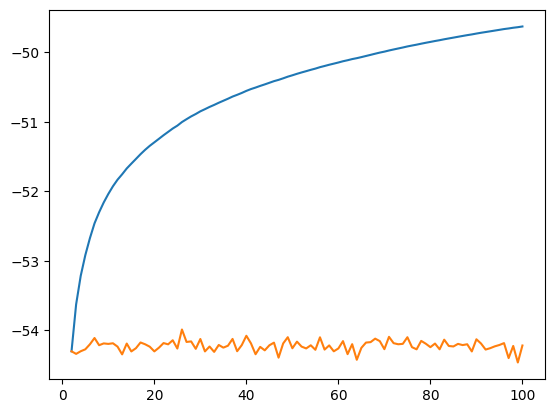

In [17]:
plt.plot(range(2, 101), marginal_likelihoods[1:])
plt.plot(range(2, 1+len(one_marg_likelihoods)), one_marg_likelihoods[1:])
plt.show()

In [27]:
%%script false --no-raise-error # comment this line out to make the cell run WARNING this takes 150 minutes (2.5 hours)

np.random.seed(1)

likelihoods = []
one_marg_likelihoods = []
ten_marg_likelihoods = []
hun_marg_likelihoods = []

for i in range(int(1e3)):
    prior_sample = null_hyp_prior_dist(3)
    likelihoods.append(null_hyp_log_lik(prior_sample, covariates, responses))

for i in range(int(1e3), int(1e4)):
    prior_sample = null_hyp_prior_dist(3)
    one_marg_likelihoods.append(logsumexp(likelihoods[i-1000:]))
    likelihoods.append(null_hyp_log_lik(prior_sample, covariates, responses))

for i in range(int(1e4), int(1e5)):
    prior_sample = null_hyp_prior_dist(3)
    one_marg_likelihoods.append(logsumexp(likelihoods[i-1000:]))
    ten_marg_likelihoods.append(logsumexp(likelihoods[i-10000:]))
    likelihoods.append(null_hyp_log_lik(prior_sample, covariates, responses))

for i in range(int(1e5), int(1e6)):
    prior_sample = null_hyp_prior_dist(3)
    one_marg_likelihoods.append(logsumexp(likelihoods[i-1000:]))
    ten_marg_likelihoods.append(logsumexp(likelihoods[i-10000:]))
    hun_marg_likelihoods.append(logsumexp(likelihoods[i-100000:]))
    likelihoods.append(null_hyp_log_lik(prior_sample, covariates, responses))

/tmp/ipykernel_67094/1388182580.py:13: RuntimeWarning: divide by zero encountered in log
  lhoods.append(fatal * np.log(prob) + (1-fatal) * np.log(1-prob))
/tmp/ipykernel_67094/1388182580.py:13: RuntimeWarning: invalid value encountered in scalar multiply
  lhoods.append(fatal * np.log(prob) + (1-fatal) * np.log(1-prob))


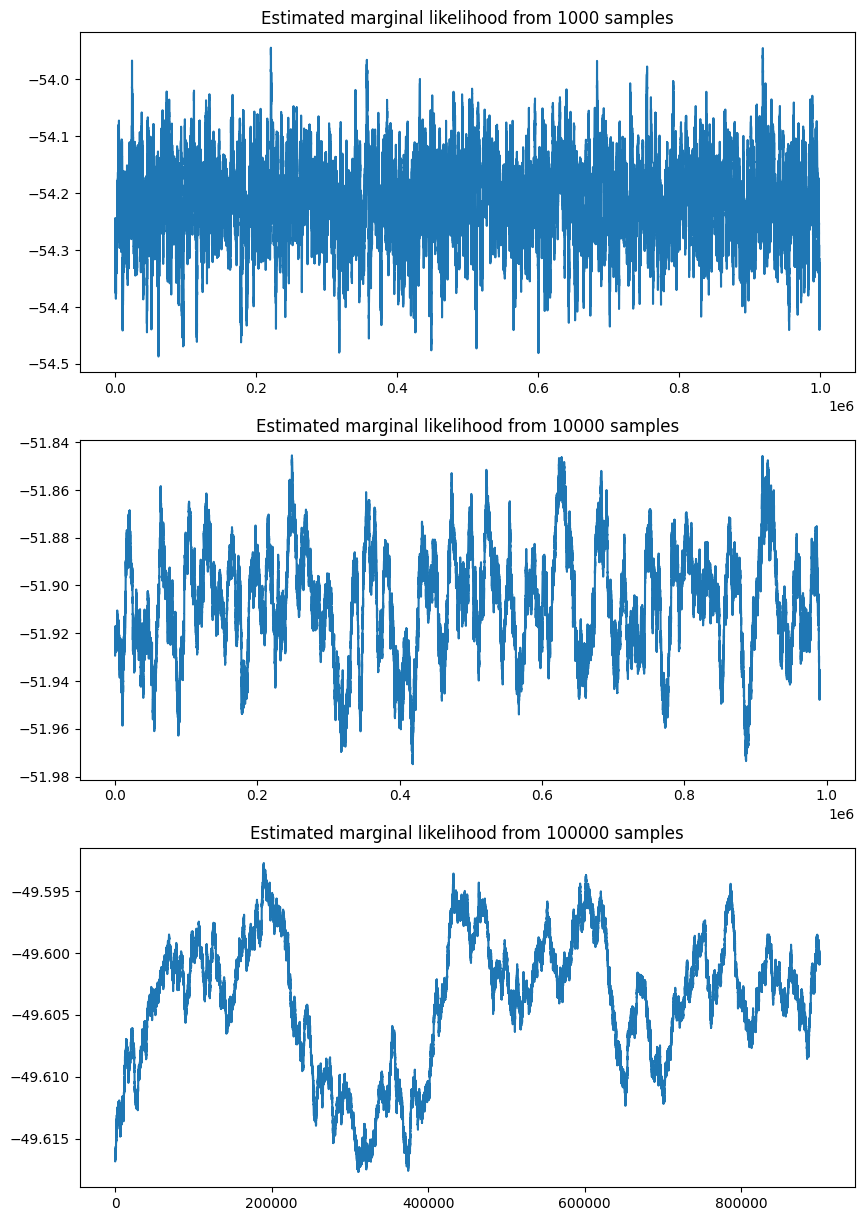

In [30]:
#%%script false --no-raise-error # comment this line out to make the cell run

fig, ax = plt.subplots(3, figsize=(10,15))

ax[0].plot(one_marg_likelihoods)
ax[0].set(title='Estimated marginal likelihood from 1000 samples')

ax[1].plot(ten_marg_likelihoods)
ax[1].set(title='Estimated marginal likelihood from 10000 samples')

ax[2].plot(hun_marg_likelihoods)
ax[2].set(title='Estimated marginal likelihood from 100000 samples')

plt.show()

In [10]:
marginal_likelihoods[-80]

-51.245070414725404

In [ ]:
logsumexp([1e-27])

1e-27

In [ ]:
data_filter = {'ADM2_name':'Dhaka',
               'EVENT_TYPE':'Battles'}

In [ ]:
np.random.seed(10)

mc_marginal_likelihood(data, 3, data_filter, prior_dist=mod4_prior_dist, likelihood=model4_log_lik, K=1000)

-56.17457690018691

In [ ]:
np.random.seed(1)

mc_marginal_likelihood(data, 3, data_filter, prior_dist=null_hyp_prior_dist, likelihood=null_hyp_log_lik, K=1000000)

/tmp/ipykernel_79167/1388182580.py:13: RuntimeWarning: divide by zero encountered in log
  lhoods.append(fatal * np.log(prob) + (1-fatal) * np.log(1-prob))
/tmp/ipykernel_79167/1388182580.py:13: RuntimeWarning: invalid value encountered in scalar multiply
  lhoods.append(fatal * np.log(prob) + (1-fatal) * np.log(1-prob))


KeyboardInterrupt: 

In [ ]:
np.random.seed(1)

marg_lik_4 = mc_marginal_likelihood(data, 3, data_filter, prior_dist=mod4_prior_dist, likelihood=model4_log_lik, K=10000)

marg_lik_null = mc_marginal_likelihood(data, 3, data_filter, prior_dist=null_hyp_prior_dist, likelihood=null_hyp_log_lik, K=10000)

marg_lik_null-marg_lik_4

2.088232859120019

#### Chib's method

The next cells attempt an implementation of Chib's method.

In [ ]:
def find_map(samples, num_bins=50):
    hist, bins = np.histogram(samples, bins=num_bins, density=True)
    map_bin_index = np.argmax(hist)
    map_estimate = (bins[map_bin_index] + bins[map_bin_index + 1]) / 2
    return map_estimate

def highest_density_samples(samples, map_estimate, quantile_range=0.01):
    distances = np.abs(samples - map_estimate)
    num_samples = len(samples)
    num_closest_samples = int(num_samples * quantile_range)
    closest_sample_indices = distances.argsort()[:num_closest_samples]
    closest_samples = samples[closest_sample_indices]
    return closest_samples

def highest_density_width(samples, map_estimate=None, quantile_range=0.01):
    hd_samples = highest_density_samples(samples, map_estimate, quantile_range)
    width = np.max(hd_samples) - np.min(hd_samples)
    return width

def density_width_count(samples, width, centre):
    lower, upper = centre-width/2, centre+width/2
    within_samples = [value for value in samples if lower <= value <= upper]
    return len(within_samples)

def samples_within_widths(samples, widths, centre):
    for idx, width in enumerate(widths):
        lower, upper = centre[idx]-width/2, centre[idx]+width/2
        samples = [sample for sample in samples if lower <= sample[idx] <= upper]
    return len(samples)

In [ ]:
model, full_chain_4 = model_sample(4, data, data_filter, 10000, stan_filepath='stan_files/model4.stan', max_bin=3)

Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%


Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 3.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
  Adjust your expectations accordingly!


In [ ]:
def multidim_map_estimate(samples, bins=50):
    if samples.ndim > 1:
        complete_map = []
        for i in range(samples.shape[1]):
            complete_map.append(find_map(samples[:,i], bins))
    else:
        complete_map = [find_map(samples, bins)]
    return complete_map

In [ ]:
def joint_map(samples, bins=50):
    hist, edges = np.histogramdd(samples, bins=bins)
    max_indices = np.unravel_index(np.argmax(hist), hist.shape)
    map_estimate = [(edges[i][max_indices[i]] + edges[i][max_indices[i] + 1])/2 for i in range(len(max_indices))]
    return map_estimate

In [ ]:
def closest_to_map(samples, max_ap, proportion=0.01):
    distances = np.linalg.norm(samples-max_ap, axis=1)
    num_samples = len(samples)
    num_closest = int(num_samples*proportion)

    closest_indices = np.argsort(distances)[:num_closest]
    closest_samples = samples[closest_indices]
    return closest_samples

def furthest_distance(close_samples, max_ap):
    distances_from_map = np.linalg.norm(close_samples-max_ap, axis=1)
    furthest = np.max(abs(distances_from_map))
    return furthest

def count_hypersphere(samples, centre, radius):
    distances = np.linalg.norm(samples-centre, axis=1)
    samples_in = np.count_nonzero(distances <= radius)
    return samples_in

In [ ]:
def one_dim_closest_to_map(samples, max_ap, proportion=0.01):
    distances = abs(samples-max_ap)
    num_samples = len(samples)
    num_closest = int(num_samples*proportion)

    closest_indices = np.argsort(distances)[:num_closest]
    closest_samples = samples[closest_indices]
    return closest_samples

def one_dim_furthest_distance(close_samples, max_ap):
    distances_from_map = close_samples - max_ap
    furthest = np.max(abs(distances_from_map))
    return furthest

def one_dim_count_hypersphere(samples, centre, radius):
    distances = samples - centre
    samples_in = np.count_nonzero(distances <= radius)
    return samples_in

In [ ]:
one_dim_closest_to_map(np.array([1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10]), 4, 0.2)

array([4, 4, 5, 3])

In [ ]:
one_dim_count_hypersphere(np.array([1,1,2,2,3,3,4,5,6,7]), 0, 2)

4

In [ ]:
samples4 = full_chain_4[['pK', 'q.2', 'q.1']].values

In [ ]:
def hypersphere_volume(radius, ndim):
    volume = np.pi**(ndim/2) * abs(radius)**ndim / gammafunc(ndim/2 + 1)
    return volume

In [ ]:
max_ap = joint_map(samples4)
closest = closest_to_map(samples4, max_ap)
radius = furthest_distance(closest, max_ap)
counted = count_hypersphere(samples4, max_ap, radius)

In [ ]:
def map_posterior_density(samples, proportion=0.01, quantile_diagnostic=True):
    dimension = samples.shape[1]
    max_ap = joint_map(samples)
    radius = furthest_distance(closest_to_map(samples, max_ap, proportion), max_ap)
    counted = count_hypersphere(samples, max_ap, radius)
    actual_proportion = counted/samples.shape[0]
    volume = hypersphere_volume(radius, dimension)
    post_density = actual_proportion/volume
    if quantile_diagnostic:
        print(f'aimed for {100*proportion}% of samples\nachieved  {100*actual_proportion}%')
    return post_density

In [ ]:
# def one_dim_map_post_density(samples, proportion=0.01):
#     max_ap = find_map(samples)
#     closest = one_dim_closest_to_map(samples, max_ap, proportion)
#     print(f'length of closest is {len(closest)}')
#     print(f'width of closest is {np.max(closest) - np.min(closest)}')
#     radius = one_dim_furthest_distance(closest, max_ap)
#     counted = one_dim_count_hypersphere(samples, max_ap, radius)
#     actual_proportion = counted/len(samples)
#     volume = hypersphere_volume(radius, 1)
#     post_density = actual_proportion/volume
#     print(f'radius {radius} \n actual_proportion {actual_proportion}')
#     return post_density

In [ ]:
def one_dim_map_post_density(samples, proportion=0.01, quantile_diagnostic=True):
    max_ap = find_map(samples)
    closest = one_dim_closest_to_map(samples, max_ap, proportion)
    width = np.max(closest) - np.min(closest)
    actual_proportion = len(closest)/len(samples)
    post_density = actual_proportion/width
    if quantile_diagnostic:
        print(f'aimed for {100*proportion}% of samples\nachieved  {100*actual_proportion}%')
    return post_density

In [ ]:
def multidim_chib_marginal_likelihood(samples, prior_lhood, likelihood, data, max_bin, data_filter, hyperparameters, quantile_range=0.01, hist_bins=50, quantile_diagnostic=True):
    map_estimate = joint_map(samples, hist_bins)

    if len(map_estimate) == 1:
        map_estimate = map_estimate[0]

    map_prior_lhood = prior_lhood(map_estimate, hyperparameters)
        
    filtered_data = filter_data_by_dict(data, data_filter)
    agg_data = temporal_aggregation(filtered_data, 'WEEK')
    bins = [i for i in range(max_bin + 1)]
    bins.append(float(('inf')))
    agg_data = bin_data(agg_data, bins=bins)

    fatality_flag = agg_data['FATALITY_FLAG'].values
    event_bins = agg_data['BINS'].values.astype(int)

    responses = [fatal for fatal, cov in zip(fatality_flag, event_bins) if cov > 0]
    covariates = [cov for cov in event_bins if cov > 0]

    map_lhood = likelihood(map_estimate, covariates, responses)

    map_post_lhood = np.log(map_posterior_density(samples, quantile_range, quantile_diagnostic=quantile_diagnostic))

    return map_lhood + map_prior_lhood - map_post_lhood

In [ ]:
def unidim_chib_marginal_likelihood(samples, prior_lhood, likelihood, data, max_bin, data_filter, hyperparameters, quantile_range=0.01, hist_bins=50, quantile_diagnostic=True):
    map_estimate = find_map(samples, hist_bins)

    map_prior_lhood = prior_lhood(map_estimate, hyperparameters)
        
    filtered_data = filter_data_by_dict(data, data_filter)
    agg_data = temporal_aggregation(filtered_data, 'WEEK')
    bins = [i for i in range(max_bin + 1)]
    bins.append(float(('inf')))
    agg_data = bin_data(agg_data, bins=bins)

    fatality_flag = agg_data['FATALITY_FLAG'].values
    event_bins = agg_data['BINS'].values.astype(int)

    responses = [fatal for fatal, cov in zip(fatality_flag, event_bins) if cov > 0]
    covariates = [cov for cov in event_bins if cov > 0]

    map_lhood = likelihood(map_estimate, covariates, responses)

    map_post_lhood = np.log(one_dim_map_post_density(samples, quantile_range, quantile_diagnostic=quantile_diagnostic))

    return map_lhood + map_prior_lhood - map_post_lhood

In [ ]:
null_prior_lhood(0.49, [1,1])

0.0

In [ ]:
stats.beta.logpdf(0.49, 1, 1)

0.0

In [ ]:
filter_dict = {'ADM2_name':'Dhaka',
               'EVENT_TYPE':'Battles'}

In [ ]:
multidim_chib_marginal_likelihood(samples4, mod4_prior_lhood, model4_log_lik, data, 3, filter_dict, [[1,1],[1,1],[1,1]], 0.01)

aimed for 1.0% of samples
achieved  1.0%


-62.55292186147845

In [ ]:
def null_hypothesis_sample(data, data_filter, max_bin, stan_filepath, sample_size=10000):

    with open(stan_filepath) as f:
        stan_code = f.read()

    filtered_data = filter_data_by_dict(data, data_filter)
    agg_data = temporal_aggregation(filtered_data, 'WEEK')

    bins = [i for i in range(max_bin + 1)]
    bins.append(float(('inf')))
    agg_data = bin_data(agg_data, bins=bins)
    fatality_flag = agg_data['FATALITY_FLAG'].values
    event_bins = agg_data['BINS'].values.astype(int)
    num_obs = len(fatality_flag)
    max_events = max_bin

    model_data = {'fatality_flag':fatality_flag,
                  'event_bins':event_bins,
                  'num_obs':num_obs,
                  'max_events':max_events}
    print('Sampling using Stan')

    return stan_sample(model_data, stan_code, size_out=sample_size)

In [ ]:
model, full_chain_null = null_hypothesis_sample(data, data_filter, 3, 'stan_files/null_model.stan')
samples_null = full_chain_null['p'].values

Sampling using Stan
Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000281 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.81 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000241 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.41 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000212 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.12 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000227 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.27 seconds.
  Adjust your expectations accordingly!


In [ ]:
log_marg_lik_4 = multidim_chib_marginal_likelihood(samples4, mod4_prior_lhood, model4_log_lik, data, 3, filter_dict, [[1,1],[1,1],[1,1]], 0.02)
log_marg_lik_null = unidim_chib_marginal_likelihood(samples_null, null_prior_lhood, null_hyp_log_lik, data, 3, filter_dict, [1,1], 0.2)

aimed for 2.0% of samples
achieved  2.0%
aimed for 20.0% of samples
achieved  20.0%


In [ ]:
unidim_chib_marginal_likelihood(samples_null, null_prior_lhood, null_hyp_log_lik, data, 3, filter_dict, [1,1], 0.02)

aimed for 2.0% of samples
achieved  2.0%


-61.09611882437718

In [ ]:
log_marg_lik_null-log_marg_lik_4

1.3906031740097973

In [ ]:
def beta_from_mean_var(mean, variance):
    if mean <= 0 or mean >= 1:
        print(f'mean of {mean}')
        print(f'variance of {variance}')
        raise ValueError('The mean must be in (0,1)')
    if variance <= 0 or variance >= mean*(1-mean):
        print(f'mean of {mean}')
        print(f'variance of {variance}')
        raise ValueError('The variance must be in (0, mu(1-mu))')
    alpha = ( (1-mean)/variance - 1/mean ) * mean**2
    beta = alpha * (1/mean - 1)
    return alpha, beta

beta_from_mean_var(np.mean(samples_null), np.var(samples_null))

In [ ]:
np.mean(samples_null)

0.49190406200503184

In [ ]:
np.var(samples_null)

0.0024083122138153735

In [ ]:
beta_from_mean_var(np.mean(samples_null), np.var(samples_null))

(50.557861550548694, 52.222061315856756)

### Numerical stability of the marginal likelihood
Justification for choice of target proportion

In [ ]:
x_axis = np.linspace(0.0005, 0.2, 100)
post_densities = []
marg_liks = []

for x in x_axis:
    marg_liks.append(multidim_chib_marginal_likelihood(samples4, mod4_prior_lhood, model4_log_lik, data, 3, filter_dict, [[1,1],[1,1],[1,1]], x, quantile_diagnostic=False))

fig, ax = plt.subplots()

ax.plot(x_axis, marg_liks)

KeyboardInterrupt: 

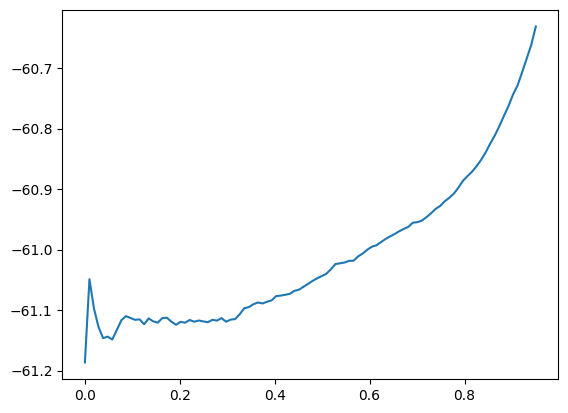

In [ ]:
x_axis = np.linspace(0.0005, 0.95, 100)
marg_liks = []

for x in x_axis:
    marg_liks.append(unidim_chib_marginal_likelihood(samples_null, null_prior_lhood, null_hyp_log_lik, data, 3, filter_dict, [1,1], x, quantile_diagnostic=False))

fig, ax = plt.subplots()

ax.plot(x_axis, marg_liks)

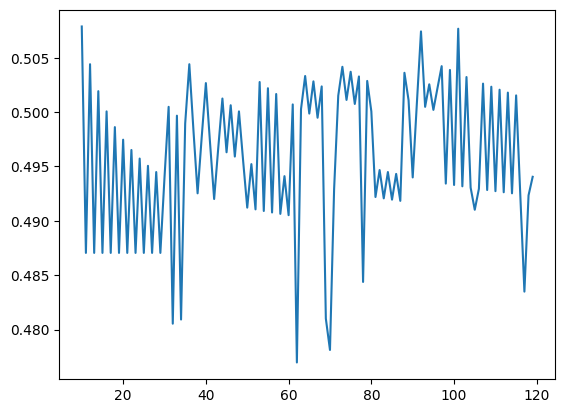

In [ ]:
x_axis = range(10, 120, 1)
max_aps = []

for bin in x_axis:
    max_aps.append(find_map(samples_null, int(bin)))

fig, ax = plt.subplots()

ax.plot(x_axis, max_aps)

In [ ]:
from general_model import sampling_visualisation

/data/florican/jamiesonball/miniconda3/envs/stan_env/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


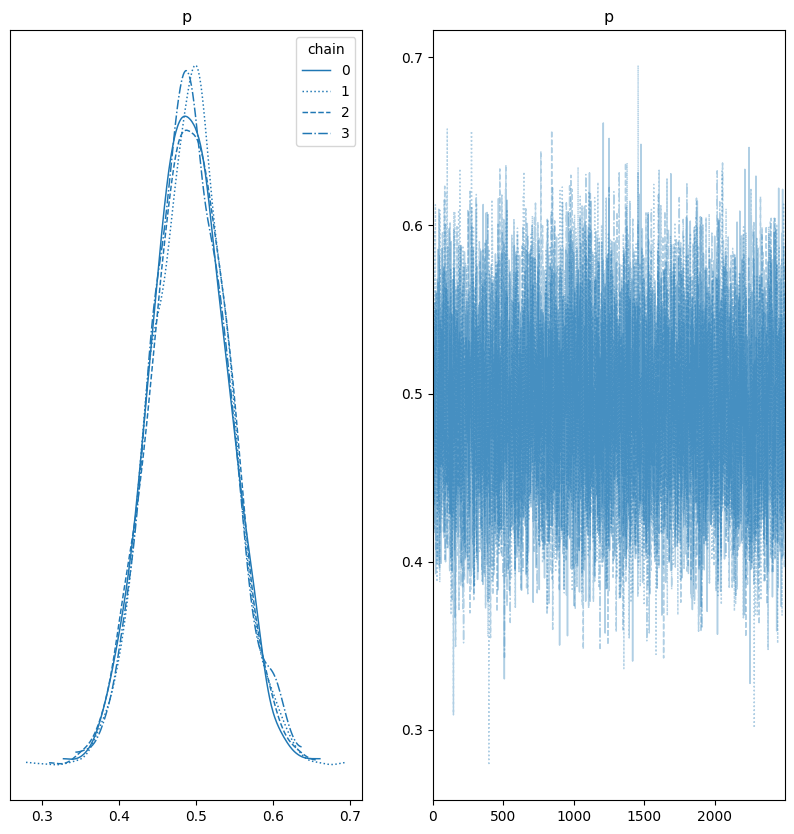

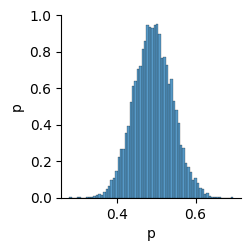

In [ ]:
sampling_visualisation(model, param_names=['p'], pairplot=True)

In [ ]:
def multidim_hd_widths(samples, map_estimate, quantile_range=0.01):
    widths = []
    for idx, position in enumerate(map_estimate):
        width = highest_density_width(samples[:,idx], position, quantile_range)
        widths.append(width)
    return widths

def highest_density_width(samples, map_estimate, quantile_range=0.01):
    hd_samples = highest_density_samples(samples, map_estimate, quantile_range)
    width = np.max(hd_samples) - np.min(hd_samples)
    return width

def map_log_post_density(samples, quantile_range=0.01, hist_bins=50):
    map_estimate = multidim_map_estimate(samples, hist_bins)
    widths = multidim_hd_widths(samples, map_estimate, quantile_range)
    proportion = samples_within_widths(samples, widths, map_estimate)/samples.shape[0]
    return np.log(proportion) - np.sum([np.log(width) for width in widths])

def log_marginal_likelihood(samples, prior_lhood, likelihood, data, max_bin, data_filter, hyperparameters, quantile_range=0.01, hist_bins=50):
    map_estimate = multidim_map_estimate(samples, hist_bins)

    if len(map_estimate) == 1:
        map_estimate = map_estimate[0]

    map_prior_lhood = prior_lhood(map_estimate, hyperparameters)
        
    filtered_data = filter_data_by_dict(data, data_filter)
    agg_data = temporal_aggregation(filtered_data, 'WEEK')
    bins = [i for i in range(max_bin + 1)]
    bins.append(float(('inf')))
    agg_data = bin_data(agg_data, bins=bins)

    fatality_flag = agg_data['FATALITY_FLAG'].values
    event_bins = agg_data['BINS'].values.astype(int)

    map_lhood = likelihood(map_estimate, event_bins, fatality_flag)

    map_post_lhood = map_log_post_density(samples, quantile_range, hist_bins)

    return map_lhood + map_prior_lhood - map_post_lhood
